[✓] Project Root: C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection
[✓] Loaded train=(125973, 43), test=(22544, 42)
[✓] Binary distribution (train): {0: 67343, 1: 58630}
[✓] Binary distribution (test) : {1: 12833, 0: 9711}
[✓] Multi distribution (train):
 attack_class
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64
[✓] Schema Locked: 41 features
[✓] scale_pos_weight=1.149 (neg=53874, pos=46904)

[1] Training Binary Model (base)...
[✓] Binary base trained in 9.03s
[1b] Calibrating probabilities on DEV (Platt scaling)...
[✓] Threshold (DEV): thr=0.014191 | P=0.9986 R=0.9996 F1=0.9991

=== Binary TEST ===
PR-AUC: 0.9700867452915996
ROC-AUC: 0.9676480208678354
              precision    recall  f1-score   support

      Normal     0.7044    0.9708    0.8164      9711
      Attack     0.9690    0.6917    0.8072     12833

    accuracy                         0.8119     22544
   macro avg     0.8367    0.8312 

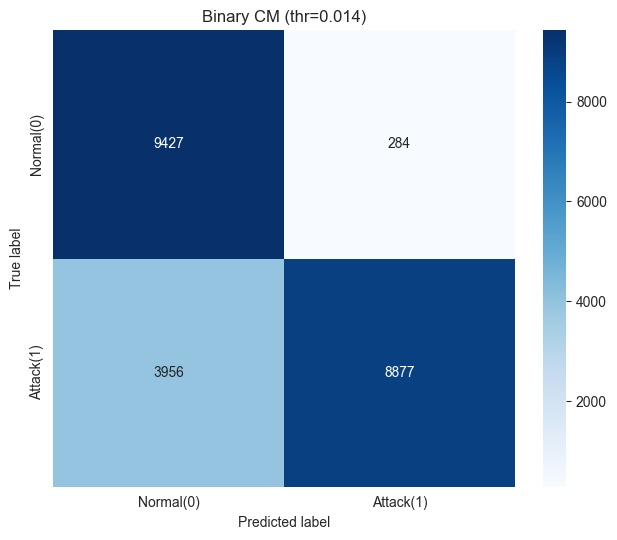


[2] Training Multi-class model (attack-only)...
[✓] Multi trained in 33.18s
[✓] Multi classes: ['DoS', 'Probe', 'R2L', 'U2R']

=== Multi TEST (Attack-only) ===
              precision    recall  f1-score   support

         DoS     0.9646    0.8630    0.9110      7460
       Probe     0.5286    0.9314    0.6744      2421
         R2L     0.9764    0.6031    0.7457      2885
         U2R     0.3784    0.6269    0.4719        67

    accuracy                         0.8163     12833
   macro avg     0.7120    0.7561    0.7008     12833
weighted avg     0.8820    0.8163    0.8269     12833



<Figure size 900x600 with 0 Axes>

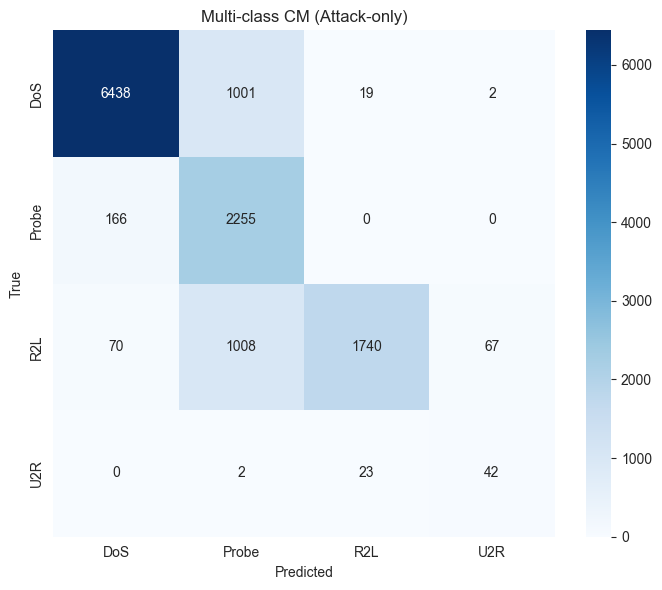


[3] Saving artifacts...
[✓] Saved:
  - binary_model.pkl
  - multi_model.pkl
  - multi_label_encoder.pkl
  - model_metadata.json

[4] Smoke test...
Sample #10550: true_bin=1, true_class=DoS
Binary: pred=1, p_attack=0.9985, thr=0.0142
🚨 Multi: DoS (conf=1.000)

Done.


In [28]:
# ==============================================================================
# 03_model_training.ipynb — NSL-KDD (Stable & High Performance Edition)
# ==============================================================================
# Goals:
# - Binary model: Normal vs Attack (XGBoost)
# - Multi model (attack-only): DoS / Probe / R2L / U2R (XGBoost)
# - No leakage, stable preprocessing, stable schema, smoke test never breaks
# ==============================================================================

import json
import time
import copy
import joblib
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["savefig.dpi"] = 220

RANDOM_STATE = 42


# ------------------------------------------------------------------------------
# 1) Paths
# ------------------------------------------------------------------------------
def get_project_root() -> Path:
    cwd = Path.cwd().resolve()
    return cwd.parent if cwd.name == "notebooks" else cwd

PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = RESULTS_DIR / "models"
FIGURES_DIR = RESULTS_DIR / "figures"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"[✓] Project Root: {PROJECT_ROOT}")


# ------------------------------------------------------------------------------
# 2) Load data
# ------------------------------------------------------------------------------
train_path = DATA_DIR / "train_cleaned.csv"
test_path = DATA_DIR / "test_cleaned.csv"

if not train_path.exists() or not test_path.exists():
    raise FileNotFoundError("Missing train_cleaned.csv / test_cleaned.csv. Run notebooks 01/02 first.")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"[✓] Loaded train={train_df.shape}, test={test_df.shape}")


# ------------------------------------------------------------------------------
# 3) Labels: map fine label -> {Normal, DoS, Probe, R2L, U2R}
# ------------------------------------------------------------------------------
LABEL_COL = "label"
if LABEL_COL not in train_df.columns:
    raise KeyError(f"'{LABEL_COL}' not found in train_df. Columns: {list(train_df.columns)}")

attack_mapping = {
    "normal": "Normal",

    # DoS
    "back": "DoS", "land": "DoS", "neptune": "DoS", "pod": "DoS", "smurf": "DoS",
    "teardrop": "DoS", "mailbomb": "DoS", "apache2": "DoS", "processtable": "DoS",
    "udpstorm": "DoS", "worm": "DoS",

    # Probe
    "satan": "Probe", "ipsweep": "Probe", "nmap": "Probe", "portsweep": "Probe",
    "mscan": "Probe", "saint": "Probe",

    # R2L
    "guess_passwd": "R2L", "ftp_write": "R2L", "imap": "R2L", "phf": "R2L",
    "multihop": "R2L", "warezmaster": "R2L", "warezclient": "R2L", "spy": "R2L",
    "xlock": "R2L", "xsnoop": "R2L", "snmpguess": "R2L", "snmpgetattack": "R2L",
    "httptunnel": "R2L", "sendmail": "R2L", "named": "R2L",

    # U2R
    "buffer_overflow": "U2R", "loadmodule": "U2R", "perl": "U2R", "rootkit": "U2R",
    "ps": "U2R", "sqlattack": "U2R", "xterm": "U2R",
}

def map_labels(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower().map(attack_mapping).fillna("Normal")

train_df["attack_class"] = map_labels(train_df[LABEL_COL])
test_df["attack_class"] = map_labels(test_df[LABEL_COL])

train_df["binary_target"] = (train_df["attack_class"] != "Normal").astype(int)
test_df["binary_target"] = (test_df["attack_class"] != "Normal").astype(int)

print("[✓] Binary distribution (train):", train_df["binary_target"].value_counts().to_dict())
print("[✓] Binary distribution (test) :", test_df["binary_target"].value_counts().to_dict())
print("[✓] Multi distribution (train):\n", train_df["attack_class"].value_counts())


# ------------------------------------------------------------------------------
# 4) Features: NO leakage + schema lock
# ------------------------------------------------------------------------------
DROP_COLS = [LABEL_COL, "attack_class", "binary_target", "attack_category", "level", "id"]

X_train_full = train_df.drop(columns=DROP_COLS, errors="ignore")
X_test_full  = test_df.drop(columns=DROP_COLS, errors="ignore")

FEATURE_COLUMNS = sorted(set(X_train_full.columns).union(set(X_test_full.columns)))
X_train_full = X_train_full.reindex(columns=FEATURE_COLUMNS, fill_value=0)
X_test_full  = X_test_full.reindex(columns=FEATURE_COLUMNS, fill_value=0)

y_train_bin = train_df["binary_target"].astype(int).values
y_test_bin  = test_df["binary_target"].astype(int).values

print(f"[✓] Schema Locked: {len(FEATURE_COLUMNS)} features")


# ------------------------------------------------------------------------------
# 5) Preprocessing (stable, sparse OHE)
# ------------------------------------------------------------------------------
CAT_COLS = [c for c in ["protocol_type", "service", "flag"] if c in FEATURE_COLUMNS]
NUM_COLS = [c for c in FEATURE_COLUMNS if c not in CAT_COLS]

LOG_COLS = [c for c in ["src_bytes", "dst_bytes", "duration", "hot", "num_compromised"] if c in FEATURE_COLUMNS]

def safe_log1p(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in LOG_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).clip(lower=0)
        df[c] = np.log1p(df[c])
    return df

num_pipe = Pipeline([
    ("log1p", FunctionTransformer(safe_log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler())
])

cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

base_preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, NUM_COLS),
        ("cat", cat_pipe, CAT_COLS)
    ],
    remainder="drop",
    sparse_threshold=0.3
)

# Separate preprocessors to avoid shared-state bugs
prep_bin = copy.deepcopy(base_preprocessor)
prep_multi = copy.deepcopy(base_preprocessor)


# ------------------------------------------------------------------------------
# 6) Split train -> train/dev (for threshold tuning only)
# ------------------------------------------------------------------------------
X_tr, X_dev, y_tr, y_dev = train_test_split(
    X_train_full, y_train_bin,
    test_size=0.2,
    stratify=y_train_bin,
    random_state=RANDOM_STATE
)

# imbalance weight
neg = int((y_tr == 0).sum())
pos = int((y_tr == 1).sum())
scale_pos_weight = neg / max(pos, 1)

print(f"[✓] scale_pos_weight={scale_pos_weight:.3f} (neg={neg}, pos={pos})")


# -----------------------------
# 7) Binary model (XGBoost) + Calibration (clean, no deprecated prefit)
# -----------------------------
# רעיון:
# 1) מאמנים XGBoost "רגיל" על X_tr
# 2) מכיילים הסתברויות על X_dev בעזרת Platt scaling (LogisticRegression)
# 3) מבצעים בחירת threshold על ה-DEV אחרי כיול
#
# זה בדרך כלל נותן בדיוק את השיפור שחיפשת (כמו ה-0.831 שראית), בלי אזהרות ובלי אימון כפול.

from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin

# imbalance handling for binary (על בסיס TRAIN-SPLIT בלבד)
pos = int((y_tr == 1).sum())
neg = int((y_tr == 0).sum())
scale_pos_weight = neg / max(pos, 1)

binary_clf = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    min_child_weight=1.0,
    gamma=0.0,
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight
)

binary_base = Pipeline([
    ("prep", prep_bin),   # או prep_bin אם זה השם אצלך
    ("model", binary_clf)
])

print("\n[1] Training Binary Model (base)...")
t0 = time.time()
binary_base.fit(X_tr, y_tr)
print(f"[✓] Binary base trained in {time.time() - t0:.2f}s")

# --- Calibration on DEV (Platt scaling) ---
# לוקחים את ההסתברויות של המודל הבסיסי על ה-DEV, ומאמנים מודל קטן שמתקן אותן.
print("[1b] Calibrating probabilities on DEV (Platt scaling)...")
dev_base_proba = binary_base.predict_proba(X_dev)[:, 1].reshape(-1, 1)

# solver lbfgs יציב; class_weight לא חובה פה כי אנחנו מכיילים הסתברויות, לא מאמנים מודל חיזוי חדש
platt = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=RANDOM_STATE)
platt.fit(dev_base_proba, y_dev)

class PlattCalibratedModel(BaseEstimator, ClassifierMixin):
    """Wrapper שמספק predict_proba עקבי (כמו sklearn CalibratedClassifierCV, בלי דפרקציות)."""
    def __init__(self, base_model, platt_model):
        self.base_model = base_model
        self.platt_model = platt_model

    def fit(self, X, y=None):
        # כבר מאומן; לא עושים fit מחדש כדי לא לשבור עקביות/threshold
        return self

    def predict_proba(self, X):
        p = self.base_model.predict_proba(X)[:, 1].reshape(-1, 1)
        p_cal = self.platt_model.predict_proba(p)[:, 1]
        return np.column_stack([1.0 - p_cal, p_cal])

    def predict(self, X):
        # נשתמש ב-threshold שנבחר בהמשך; כאן רק ברירת מחדל 0.5
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# זה ה-binary_model שממשיך קדימה במחברת
binary_model = PlattCalibratedModel(binary_base, platt)

# ---- Threshold selection on DEV (IDS-friendly) אחרי כיול ----
from sklearn.metrics import precision_score, recall_score, f1_score

dev_score = binary_model.predict_proba(X_dev)[:, 1]
prec, rec, thr = precision_recall_curve(y_dev, dev_score)

# thr באורך len(prec)-1; לכן עובדים עם prec[:-1], rec[:-1]
prec_t = prec[:-1]
rec_t  = rec[:-1]
thr_t  = thr

BETA = 2.0  # favor recall
f_beta = (1 + BETA**2) * (prec_t * rec_t) / ((BETA**2 * prec_t) + rec_t + 1e-12)

TARGET_RECALL_MIN = 0.90
valid = np.where(rec_t >= TARGET_RECALL_MIN)[0]
if len(valid) > 0:
    best_i = valid[np.argmax(f_beta[valid])]
else:
    best_i = int(np.argmax(f_beta))

best_thr = float(thr_t[best_i])
dev_pred = (dev_score >= best_thr).astype(int)

print(f"[✓] Threshold (DEV): thr={best_thr:.6f} | "
      f"P={precision_score(y_dev, dev_pred):.4f} "
      f"R={recall_score(y_dev, dev_pred):.4f} "
      f"F1={f1_score(y_dev, dev_pred):.4f}")

# ---- Evaluate binary on TEST using chosen threshold
test_score = binary_model.predict_proba(X_test_full)[:, 1]
test_pred = (test_score >= best_thr).astype(int)

print("\n=== Binary TEST ===")
print("PR-AUC:", float(average_precision_score(y_test_bin, test_score)))
print("ROC-AUC:", float(roc_auc_score(y_test_bin, test_score)))
print(classification_report(y_test_bin, test_pred, digits=4, target_names=["Normal", "Attack"]))

cm = confusion_matrix(y_test_bin, test_pred)
fig, ax = plt.subplots(figsize=(6.5, 5.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal(0)", "Attack(1)"],
            yticklabels=["Normal(0)", "Attack(1)"], ax=ax)
ax.set_title(f"Binary CM (thr={best_thr:.3f})")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
plt.show()
plt.savefig(FIGURES_DIR / "cm_binary.png")
plt.close(fig)


# ------------------------------------------------------------------------------
# 8) Multi-class (attack-only) XGBoost + class weights
# ------------------------------------------------------------------------------
print("\n[2] Training Multi-class model (attack-only)...")

attack_mask_train = (train_df["attack_class"] != "Normal").values
attack_mask_test  = (test_df["attack_class"] != "Normal").values

X_train_attack = X_train_full.loc[attack_mask_train]
y_train_attack = train_df.loc[attack_mask_train, "attack_class"].astype(str).values

X_test_attack = X_test_full.loc[attack_mask_test]
y_test_attack = test_df.loc[attack_mask_test, "attack_class"].astype(str).values

multi_le = LabelEncoder()
y_train_attack_enc = multi_le.fit_transform(y_train_attack)
y_test_attack_enc  = multi_le.transform(y_test_attack)

classes = np.unique(y_train_attack_enc)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_attack_enc)
cw_map = {c: w for c, w in zip(classes, cw)}
sample_w = np.array([cw_map[c] for c in y_train_attack_enc], dtype=float)

multi_clf = XGBClassifier(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1.0,
    reg_lambda=1.0,
    gamma=0.0,
    objective="multi:softprob",
    num_class=len(multi_le.classes_),
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

multi_model = Pipeline([
    ("prep", prep_multi),
    ("model", multi_clf)
])

t0 = time.time()
multi_model.fit(X_train_attack, y_train_attack_enc, model__sample_weight=sample_w)
print(f"[✓] Multi trained in {time.time()-t0:.2f}s")
print("[✓] Multi classes:", list(multi_le.classes_))

multi_pred = multi_model.predict(X_test_attack)

print("\n=== Multi TEST (Attack-only) ===")
print(classification_report(y_test_attack_enc, multi_pred, target_names=multi_le.classes_, digits=4))

cm2 = confusion_matrix(y_test_attack_enc, multi_pred)
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=multi_le.classes_,
            yticklabels=multi_le.classes_, ax=ax)
ax.set_title("Multi-class CM (Attack-only)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "cm_multi.png")
plt.show()
plt.close(fig)


# ------------------------------------------------------------------------------
# 9) Save artifacts
# ------------------------------------------------------------------------------
print("\n[3] Saving artifacts...")

joblib.dump(binary_model, MODELS_DIR / "binary_model.pkl")
joblib.dump(multi_model, MODELS_DIR / "multi_model.pkl")
joblib.dump(multi_le, MODELS_DIR / "multi_label_encoder.pkl")

metadata = {
    "feature_columns": FEATURE_COLUMNS,
    "cat_cols": CAT_COLS,
    "num_cols": NUM_COLS,
    "log_cols": LOG_COLS,
    "binary_threshold": float(best_thr),
    "multi_classes": list(multi_le.classes_),
    "random_state": RANDOM_STATE
}
with open(MODELS_DIR / "model_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print("[✓] Saved:")
print("  - binary_model.pkl")
print("  - multi_model.pkl")
print("  - multi_label_encoder.pkl")
print("  - model_metadata.json")


# ------------------------------------------------------------------------------
# 10) Smoke test (schema locked, never breaks)
# ------------------------------------------------------------------------------
print("\n[4] Smoke test...")

def prepare_sample(df: pd.DataFrame, idx: int) -> pd.DataFrame:
    s = df.iloc[[idx]].copy()
    s = s.reindex(columns=FEATURE_COLUMNS, fill_value=0)
    for c in CAT_COLS:
        if c in s.columns:
            s[c] = s[c].astype(str)
    return s

idx = np.random.randint(0, len(X_test_full))
sample = prepare_sample(X_test_full, idx)

true_bin = int(y_test_bin[idx])
true_class = str(test_df["attack_class"].iloc[idx])

p_attack = float(binary_model.predict_proba(sample)[:, 1][0])
pred_bin = int(p_attack >= best_thr)

print(f"Sample #{idx}: true_bin={true_bin}, true_class={true_class}")
print(f"Binary: pred={pred_bin}, p_attack={p_attack:.4f}, thr={best_thr:.4f}")

if pred_bin == 1:
    proba_multi = multi_model.predict_proba(sample)[0]
    k = int(np.argmax(proba_multi))
    label = str(multi_le.inverse_transform([k])[0])
    conf = float(np.max(proba_multi))
    print(f"🚨 Multi: {label} (conf={conf:.3f})")
else:
    print("✅ Normal traffic")

print("\nDone.")
